# Comparing simulation output for correlation estimation

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

In [143]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [144]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')
import memento
import memento.auxillary.simulate as simulate

In [145]:
data_path = '/home/ubuntu/Data/'


In [146]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
%autoreload 2

In [148]:
DATA_PATH = '/home/ubuntu/Data/'

### Calculate concordances

In [180]:
def concordance(x, y, mask, log=False):
    
    cond = mask

    if log:
        a = np.log(x[cond])
        b = np.log(y[cond])
    else:
        a = x[cond]
        b = y[cond]
    return cond.sum(), stats.pearsonr(a, b)[0]
    cmat = np.cov(a, b)
    return cond.sum(), 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [181]:
# Read smfish estimates
smfish_estimates = np.load(data_path + 'smfish/smfish_estimates.npz')
smfish_genes = list(smfish_estimates['corr_genes'])
print('number of fish gene pairs' ,len(smfish_genes))
smfish_correlations = smfish_estimates['correlation']

# Mean one includes GAPDH so remove that
# smfish_means = np.array([m for g,m in zip(smfish_estimates['mean_genes'], smfish_estimates['mean']) if g != 'GAPDH'])

# smfish_means = np.array([m for g,m in zip(smfish_estimates['mean_genes'], smfish_estimates['mean']) if g != 'GAPDH'])
# smfish_cv = smfish_variances/smfish_means**2

number of fish gene pairs 190


In [182]:
len(smfish_estimates['mean_genes'])

21

In [183]:
len(smfish_genes)

190

In [184]:
dropseq_genes = sc.read_h5ad(data_path + 'smfish/filtered_dropseq.h5ad').var.index.tolist()
smfish_gene_idxs = [dropseq_genes.index(smg) for smg in smfish_estimates['mean_genes']]
# gapdh_idx = dropseq_genes.index('GAPDH')

In [185]:
# !source activate mementocxg ; python /home/ubuntu/Github/scrna-parameter-estimation/smfish/correlation/correlation_estimation.py > temp.log


In [186]:
correlations = np.load(data_path + 'smfish/correlation/sample_correlations.npz')['correlations']
meta = pd.read_csv(data_path + 'smfish/correlation/sample_metadata.csv')

gene_names = [f'gene_{i}' for i in range(correlations.shape[1])]

results = pd.concat([
    meta, 
    pd.DataFrame(correlations, columns=gene_names)],
    axis=1).dropna(how='all')

In [187]:
concordances = []
for name, group in results.groupby(['num_cell', 'trial']):
    methods = group['method']
    num_cell, trial = name
    indices = np.all(np.isfinite(group[gene_names].values), axis=0) & np.isfinite(smfish_correlations)
    if indices.sum() < 2:
        continue
    for idx, method in enumerate(methods):
    
        estimates = group[gene_names].values[idx]
        
        num_genes_used, c = concordance(estimates, smfish_correlations, indices)

        concordances.append((
            num_cell, 
            trial,
            method,
            num_genes_used,
            c
        ))
    
concordances = pd.DataFrame(concordances, columns=['num_cell', 'trial', 'method','num_valid_genes',  'concordance'])

In [188]:
concordances.groupby(['num_cell', 'method'])['concordance'].median()

num_cell  method        
500.0     hypergeometric    0.186886
          naive             0.093638
          poisson           0.212986
          saver             0.127313
1000.0    hypergeometric    0.239921
          naive             0.170459
          poisson           0.223969
          saver             0.211483
5000.0    hypergeometric    0.480740
          naive             0.296998
          poisson           0.504433
          saver             0.375621
8000.0    hypergeometric    0.534633
          naive             0.298768
          poisson           0.559139
          saver             0.375344
Name: concordance, dtype: float64

In [189]:
def plot_curve(x, y, data, ax, marker, color, markersize, linestyle='-', label=''):
    
    agg_data = data.groupby(x)[y].agg(['mean', 'std', 'count'])
    x_data = agg_data.index
    y_data = agg_data['mean'].values
    y_err = agg_data['std']/np.sqrt(agg_data['count'])
    
    ax.plot(np.arange(x_data.shape[0]), y_data, marker=marker, color=color, markersize=markersize, linestyle=linestyle, label=label)
    ax.fill_between(np.arange(x_data.shape[0]), y_data-y_err, y_data+y_err, alpha=0.2, color=color)
    ax.set_xticks(np.arange(x_data.shape[0]), x_data.astype(int))

Text(0.5, 0, 'Num cell')

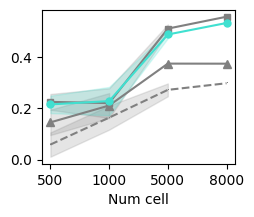

In [198]:
fig, ax = plt.subplots(figsize=(2.5,2))
to_use = concordances.query('num_valid_genes > 15')

plot_curve('num_cell', 'concordance', 
           data=to_use.query('method == "poisson"'),
           ax=ax, 
           color='gray', 
           marker="s", 
           markersize=5,
           label='Poisson')

plot_curve('num_cell', 'concordance', 
           data=to_use.query('method == "saver"'),
           ax=ax, 
           color='gray', 
           marker='^', 
           markersize=6,
           label='saver')

plot_curve('num_cell', 'concordance', 
           data=to_use.query('method == "naive"'),
           ax=ax, 
           color='gray', 
           marker=",", 
           linestyle='--',
           markersize=5,
           label='naive')

plot_curve('num_cell', 'concordance', 
           data=to_use.query('method == "hypergeometric"'),
           ax=ax, 
           color='turquoise',
           marker='o', 
           markersize=5,
           label='memento')

plt.xlabel('Num cell')
# plt.ylabel('Concordance')
# plt.legend(frameon=False)
# plt.savefig('correlation_fish.pdf', bbox_inches='tight')